In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 bz9qx60v


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-bz9qx60v:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.9


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                    | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                            | 1/1870 [00:00<23:37,  1.32it/s]

  0%|▎                                                                                                           | 6/1870 [00:00<03:31,  8.83it/s]

  1%|▋                                                                                                          | 11/1870 [00:00<01:56, 15.89it/s]

  1%|▉                                                                                                          | 16/1870 [00:01<01:23, 22.16it/s]

  1%|█▏                                                                                                         | 21/1870 [00:01<01:07, 27.43it/s]

  1%|█▍                                                                                                         | 26/1870 [00:01<00:58, 31.68it/s]

  2%|█▊                                                                                                         | 31/1870 [00:01<00:52, 34.98it/s]

  2%|██                                                                                                         | 36/1870 [00:01<00:48, 37.45it/s]

  2%|██▎                                                                                                        | 41/1870 [00:01<00:46, 39.31it/s]

  2%|██▋                                                                                                        | 46/1870 [00:01<00:44, 40.66it/s]

  3%|██▉                                                                                                        | 51/1870 [00:01<00:43, 41.64it/s]

  3%|███▏                                                                                                       | 56/1870 [00:02<00:42, 42.33it/s]

  3%|███▍                                                                                                       | 61/1870 [00:02<00:42, 42.82it/s]

  4%|███▊                                                                                                       | 66/1870 [00:02<00:41, 43.16it/s]

  4%|████                                                                                                       | 71/1870 [00:02<00:41, 43.40it/s]

  4%|████▎                                                                                                      | 76/1870 [00:02<00:41, 43.56it/s]

  4%|████▋                                                                                                      | 81/1870 [00:02<00:40, 43.69it/s]

  5%|████▉                                                                                                      | 86/1870 [00:02<00:40, 43.78it/s]

  5%|█████▏                                                                                                     | 91/1870 [00:02<00:40, 43.85it/s]

  5%|█████▍                                                                                                     | 96/1870 [00:02<00:40, 43.88it/s]

  5%|█████▋                                                                                                    | 101/1870 [00:03<00:40, 43.90it/s]

  6%|██████                                                                                                    | 106/1870 [00:03<00:40, 43.93it/s]

  6%|██████▎                                                                                                   | 111/1870 [00:03<00:40, 43.96it/s]

  6%|██████▌                                                                                                   | 116/1870 [00:03<00:40, 43.76it/s]

  6%|██████▊                                                                                                   | 121/1870 [00:03<00:39, 43.82it/s]

  7%|███████▏                                                                                                  | 126/1870 [00:03<00:39, 43.86it/s]

  7%|███████▍                                                                                                  | 131/1870 [00:03<00:39, 43.88it/s]

  7%|███████▋                                                                                                  | 136/1870 [00:03<00:39, 43.90it/s]

  8%|███████▉                                                                                                  | 141/1870 [00:03<00:39, 43.94it/s]

  8%|████████▎                                                                                                 | 146/1870 [00:04<00:39, 43.96it/s]

  8%|████████▌                                                                                                 | 151/1870 [00:04<00:39, 43.95it/s]

  8%|████████▊                                                                                                 | 156/1870 [00:04<00:38, 43.97it/s]

  9%|█████████▏                                                                                                | 161/1870 [00:04<00:38, 43.97it/s]

  9%|█████████▍                                                                                                | 166/1870 [00:04<00:38, 43.95it/s]

  9%|█████████▋                                                                                                | 171/1870 [00:04<00:38, 43.96it/s]

  9%|█████████▉                                                                                                | 176/1870 [00:04<00:38, 43.95it/s]

 10%|██████████▎                                                                                               | 181/1870 [00:04<00:38, 43.95it/s]

 10%|██████████▌                                                                                               | 186/1870 [00:04<00:38, 43.96it/s]

 10%|██████████▊                                                                                               | 191/1870 [00:05<00:38, 43.97it/s]

 10%|███████████                                                                                               | 196/1870 [00:05<00:38, 43.93it/s]

 11%|███████████▍                                                                                              | 201/1870 [00:05<00:37, 43.96it/s]

 11%|███████████▋                                                                                              | 206/1870 [00:05<00:37, 43.98it/s]

 11%|███████████▉                                                                                              | 211/1870 [00:05<00:37, 43.97it/s]

 12%|████████████▏                                                                                             | 216/1870 [00:05<00:37, 43.98it/s]

 12%|████████████▌                                                                                             | 221/1870 [00:05<00:37, 43.96it/s]

 12%|████████████▊                                                                                             | 226/1870 [00:05<00:37, 43.97it/s]

 12%|█████████████                                                                                             | 231/1870 [00:05<00:37, 43.96it/s]

 13%|█████████████▍                                                                                            | 236/1870 [00:06<00:37, 43.97it/s]

 13%|█████████████▋                                                                                            | 241/1870 [00:06<00:37, 43.98it/s]

 13%|█████████████▉                                                                                            | 246/1870 [00:06<00:36, 43.98it/s]

 13%|██████████████▏                                                                                           | 251/1870 [00:06<00:36, 43.98it/s]

 14%|██████████████▌                                                                                           | 256/1870 [00:06<00:36, 43.99it/s]

 14%|██████████████▊                                                                                           | 261/1870 [00:06<00:36, 43.99it/s]

 14%|███████████████                                                                                           | 266/1870 [00:06<00:36, 44.00it/s]

 14%|███████████████▎                                                                                          | 271/1870 [00:06<00:36, 44.00it/s]

 15%|███████████████▋                                                                                          | 276/1870 [00:07<00:36, 43.99it/s]

 15%|███████████████▉                                                                                          | 281/1870 [00:07<00:36, 43.94it/s]

 15%|████████████████▏                                                                                         | 286/1870 [00:07<00:36, 43.97it/s]

 16%|████████████████▍                                                                                         | 291/1870 [00:07<00:35, 43.98it/s]

 16%|████████████████▊                                                                                         | 296/1870 [00:07<00:35, 43.98it/s]

 16%|█████████████████                                                                                         | 301/1870 [00:07<00:35, 43.99it/s]

 16%|█████████████████▎                                                                                        | 306/1870 [00:07<00:35, 44.00it/s]

 17%|█████████████████▋                                                                                        | 311/1870 [00:07<00:35, 44.00it/s]

 17%|█████████████████▉                                                                                        | 316/1870 [00:07<00:35, 44.00it/s]

 17%|██████████████████▏                                                                                       | 321/1870 [00:08<00:35, 43.97it/s]

 17%|██████████████████▍                                                                                       | 326/1870 [00:08<00:35, 43.98it/s]

 18%|██████████████████▊                                                                                       | 331/1870 [00:08<00:35, 43.96it/s]

 18%|███████████████████                                                                                       | 336/1870 [00:08<00:34, 43.98it/s]

 18%|███████████████████▎                                                                                      | 341/1870 [00:08<00:34, 43.98it/s]

 19%|███████████████████▌                                                                                      | 346/1870 [00:08<00:34, 43.98it/s]

 19%|███████████████████▉                                                                                      | 351/1870 [00:08<00:34, 43.98it/s]

 19%|████████████████████▏                                                                                     | 356/1870 [00:08<00:34, 43.97it/s]

 19%|████████████████████▍                                                                                     | 361/1870 [00:08<00:34, 43.95it/s]

 20%|████████████████████▋                                                                                     | 366/1870 [00:09<00:34, 43.96it/s]

 20%|█████████████████████                                                                                     | 371/1870 [00:09<00:34, 43.98it/s]

 20%|█████████████████████▎                                                                                    | 376/1870 [00:09<00:33, 43.98it/s]

 20%|█████████████████████▌                                                                                    | 381/1870 [00:09<00:33, 43.99it/s]

 21%|█████████████████████▉                                                                                    | 386/1870 [00:09<00:33, 43.99it/s]

 21%|██████████████████████▏                                                                                   | 391/1870 [00:09<00:33, 43.99it/s]

 21%|██████████████████████▍                                                                                   | 396/1870 [00:09<00:33, 43.98it/s]

 21%|██████████████████████▋                                                                                   | 401/1870 [00:09<00:33, 43.98it/s]

 22%|███████████████████████                                                                                   | 406/1870 [00:09<00:33, 43.97it/s]

 22%|███████████████████████▎                                                                                  | 411/1870 [00:10<00:33, 43.97it/s]

 22%|███████████████████████▌                                                                                  | 416/1870 [00:10<00:33, 43.97it/s]

 23%|███████████████████████▊                                                                                  | 421/1870 [00:10<00:32, 43.96it/s]

 23%|████████████████████████▏                                                                                 | 426/1870 [00:10<00:32, 43.98it/s]

 23%|████████████████████████▍                                                                                 | 431/1870 [00:10<00:32, 43.98it/s]

 23%|████████████████████████▋                                                                                 | 436/1870 [00:10<00:32, 43.99it/s]

 24%|████████████████████████▉                                                                                 | 441/1870 [00:10<00:32, 44.00it/s]

 24%|█████████████████████████▎                                                                                | 446/1870 [00:10<00:32, 44.00it/s]

 24%|█████████████████████████▌                                                                                | 451/1870 [00:10<00:32, 43.95it/s]

 24%|█████████████████████████▊                                                                                | 456/1870 [00:11<00:32, 43.91it/s]

 25%|██████████████████████████▏                                                                               | 461/1870 [00:11<00:32, 43.93it/s]

 25%|██████████████████████████▍                                                                               | 466/1870 [00:11<00:31, 43.95it/s]

 25%|██████████████████████████▋                                                                               | 471/1870 [00:11<00:31, 43.97it/s]

 25%|██████████████████████████▉                                                                               | 476/1870 [00:11<00:31, 43.98it/s]

 26%|███████████████████████████▎                                                                              | 481/1870 [00:11<00:31, 43.97it/s]

 26%|███████████████████████████▌                                                                              | 486/1870 [00:11<00:31, 43.98it/s]

 26%|███████████████████████████▊                                                                              | 491/1870 [00:11<00:31, 43.97it/s]

 27%|████████████████████████████                                                                              | 496/1870 [00:12<00:31, 43.97it/s]

 27%|████████████████████████████▍                                                                             | 501/1870 [00:12<00:31, 43.96it/s]

 27%|████████████████████████████▋                                                                             | 506/1870 [00:12<00:31, 43.96it/s]

 27%|████████████████████████████▉                                                                             | 511/1870 [00:12<00:30, 43.94it/s]

 28%|█████████████████████████████▏                                                                            | 516/1870 [00:12<00:30, 43.94it/s]

 28%|█████████████████████████████▌                                                                            | 521/1870 [00:12<00:30, 43.94it/s]

 28%|█████████████████████████████▊                                                                            | 526/1870 [00:12<00:30, 43.96it/s]

 28%|██████████████████████████████                                                                            | 531/1870 [00:12<00:30, 43.96it/s]

 29%|██████████████████████████████▍                                                                           | 536/1870 [00:12<00:30, 43.97it/s]

 29%|██████████████████████████████▋                                                                           | 541/1870 [00:13<00:30, 43.94it/s]

 29%|██████████████████████████████▉                                                                           | 546/1870 [00:13<00:30, 43.92it/s]

 29%|███████████████████████████████▏                                                                          | 551/1870 [00:13<00:30, 43.93it/s]

 30%|███████████████████████████████▌                                                                          | 556/1870 [00:13<00:29, 43.96it/s]

 30%|███████████████████████████████▊                                                                          | 561/1870 [00:13<00:29, 43.96it/s]

 30%|████████████████████████████████                                                                          | 566/1870 [00:13<00:29, 43.96it/s]

 31%|████████████████████████████████▎                                                                         | 571/1870 [00:13<00:29, 43.97it/s]

 31%|████████████████████████████████▋                                                                         | 576/1870 [00:13<00:29, 43.93it/s]

 31%|████████████████████████████████▉                                                                         | 581/1870 [00:13<00:29, 43.94it/s]

 31%|█████████████████████████████████▏                                                                        | 586/1870 [00:14<00:29, 43.98it/s]

 32%|█████████████████████████████████▌                                                                        | 591/1870 [00:14<00:29, 44.00it/s]

 32%|█████████████████████████████████▊                                                                        | 596/1870 [00:14<00:28, 44.02it/s]

 32%|██████████████████████████████████                                                                        | 601/1870 [00:14<00:28, 44.00it/s]

 32%|██████████████████████████████████▎                                                                       | 606/1870 [00:14<00:28, 44.01it/s]

 33%|██████████████████████████████████▋                                                                       | 611/1870 [00:14<00:28, 44.00it/s]

 33%|██████████████████████████████████▉                                                                       | 616/1870 [00:14<00:28, 44.00it/s]

 33%|███████████████████████████████████▏                                                                      | 621/1870 [00:14<00:28, 43.99it/s]

 33%|███████████████████████████████████▍                                                                      | 626/1870 [00:14<00:28, 44.00it/s]

 34%|███████████████████████████████████▊                                                                      | 631/1870 [00:15<00:28, 44.00it/s]

 34%|████████████████████████████████████                                                                      | 636/1870 [00:15<00:28, 44.00it/s]

 34%|████████████████████████████████████▎                                                                     | 641/1870 [00:15<00:27, 43.99it/s]

 35%|████████████████████████████████████▌                                                                     | 646/1870 [00:15<00:27, 43.96it/s]

 35%|████████████████████████████████████▉                                                                     | 651/1870 [00:15<00:27, 43.98it/s]

 35%|█████████████████████████████████████▏                                                                    | 656/1870 [00:15<00:27, 43.99it/s]

 35%|█████████████████████████████████████▍                                                                    | 661/1870 [00:15<00:27, 43.99it/s]

 36%|█████████████████████████████████████▊                                                                    | 666/1870 [00:15<00:27, 43.98it/s]

 36%|██████████████████████████████████████                                                                    | 671/1870 [00:15<00:27, 43.98it/s]

 36%|██████████████████████████████████████▎                                                                   | 676/1870 [00:16<00:27, 43.98it/s]

 36%|██████████████████████████████████████▌                                                                   | 681/1870 [00:16<00:27, 43.97it/s]

 37%|██████████████████████████████████████▉                                                                   | 686/1870 [00:16<00:26, 43.99it/s]

 37%|███████████████████████████████████████▏                                                                  | 691/1870 [00:16<00:26, 44.01it/s]

 37%|███████████████████████████████████████▍                                                                  | 696/1870 [00:16<00:26, 44.01it/s]

 37%|███████████████████████████████████████▋                                                                  | 701/1870 [00:16<00:26, 44.01it/s]

 38%|████████████████████████████████████████                                                                  | 706/1870 [00:16<00:26, 44.00it/s]

 38%|████████████████████████████████████████▎                                                                 | 711/1870 [00:16<00:26, 44.01it/s]

 38%|████████████████████████████████████████▌                                                                 | 716/1870 [00:17<00:26, 44.00it/s]

 39%|████████████████████████████████████████▊                                                                 | 721/1870 [00:17<00:26, 43.99it/s]

 39%|█████████████████████████████████████████▏                                                                | 726/1870 [00:17<00:25, 44.00it/s]

 39%|█████████████████████████████████████████▍                                                                | 731/1870 [00:17<00:25, 43.97it/s]

 39%|█████████████████████████████████████████▋                                                                | 736/1870 [00:17<00:25, 43.97it/s]

 40%|██████████████████████████████████████████                                                                | 741/1870 [00:17<00:25, 43.99it/s]

 40%|██████████████████████████████████████████▎                                                               | 746/1870 [00:17<00:25, 44.00it/s]

 40%|██████████████████████████████████████████▌                                                               | 751/1870 [00:17<00:25, 44.00it/s]

 40%|██████████████████████████████████████████▊                                                               | 756/1870 [00:17<00:25, 44.00it/s]

 41%|███████████████████████████████████████████▏                                                              | 761/1870 [00:18<00:25, 44.01it/s]

 41%|███████████████████████████████████████████▍                                                              | 766/1870 [00:18<00:25, 43.99it/s]

 41%|███████████████████████████████████████████▋                                                              | 771/1870 [00:18<00:24, 43.98it/s]

 41%|███████████████████████████████████████████▉                                                              | 776/1870 [00:18<00:24, 43.98it/s]

 42%|████████████████████████████████████████████▎                                                             | 781/1870 [00:18<00:24, 43.98it/s]

 42%|████████████████████████████████████████████▌                                                             | 786/1870 [00:18<00:24, 43.98it/s]

 42%|████████████████████████████████████████████▊                                                             | 791/1870 [00:18<00:24, 43.97it/s]

 43%|█████████████████████████████████████████████                                                             | 796/1870 [00:18<00:24, 44.00it/s]

 43%|█████████████████████████████████████████████▍                                                            | 801/1870 [00:18<00:24, 43.99it/s]

 43%|█████████████████████████████████████████████▋                                                            | 806/1870 [00:19<00:24, 43.99it/s]

 43%|█████████████████████████████████████████████▉                                                            | 811/1870 [00:19<00:24, 43.99it/s]

 44%|██████████████████████████████████████████████▎                                                           | 816/1870 [00:19<00:23, 44.00it/s]

 44%|██████████████████████████████████████████████▌                                                           | 821/1870 [00:19<00:23, 43.94it/s]

 44%|██████████████████████████████████████████████▊                                                           | 826/1870 [00:19<00:23, 43.96it/s]

 44%|███████████████████████████████████████████████                                                           | 831/1870 [00:19<00:23, 43.97it/s]

 45%|███████████████████████████████████████████████▍                                                          | 836/1870 [00:19<00:23, 43.97it/s]

 45%|███████████████████████████████████████████████▋                                                          | 841/1870 [00:19<00:23, 43.99it/s]

 45%|███████████████████████████████████████████████▉                                                          | 846/1870 [00:19<00:23, 43.99it/s]

 46%|████████████████████████████████████████████████▏                                                         | 851/1870 [00:20<00:23, 44.01it/s]

 46%|████████████████████████████████████████████████▌                                                         | 856/1870 [00:20<00:23, 44.00it/s]

 46%|████████████████████████████████████████████████▊                                                         | 861/1870 [00:20<00:22, 44.00it/s]

 46%|█████████████████████████████████████████████████                                                         | 866/1870 [00:20<00:22, 43.99it/s]

 47%|█████████████████████████████████████████████████▎                                                        | 871/1870 [00:20<00:22, 44.01it/s]

 47%|█████████████████████████████████████████████████▋                                                        | 876/1870 [00:20<00:22, 44.01it/s]

 47%|█████████████████████████████████████████████████▉                                                        | 881/1870 [00:20<00:22, 44.01it/s]

 47%|██████████████████████████████████████████████████▏                                                       | 886/1870 [00:20<00:22, 44.01it/s]

 48%|██████████████████████████████████████████████████▌                                                       | 891/1870 [00:20<00:22, 44.01it/s]

 48%|██████████████████████████████████████████████████▊                                                       | 896/1870 [00:21<00:22, 44.00it/s]

 48%|███████████████████████████████████████████████████                                                       | 901/1870 [00:21<00:22, 43.99it/s]

 48%|███████████████████████████████████████████████████▎                                                      | 906/1870 [00:21<00:21, 43.98it/s]

 49%|███████████████████████████████████████████████████▋                                                      | 911/1870 [00:21<00:21, 43.97it/s]

 49%|███████████████████████████████████████████████████▉                                                      | 916/1870 [00:21<00:21, 43.98it/s]

 49%|████████████████████████████████████████████████████▏                                                     | 921/1870 [00:21<00:21, 43.95it/s]

 50%|████████████████████████████████████████████████████▍                                                     | 926/1870 [00:21<00:21, 43.96it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 931/1870 [00:21<00:21, 43.96it/s]

 50%|█████████████████████████████████████████████████████                                                     | 936/1870 [00:22<00:21, 43.98it/s]

 50%|█████████████████████████████████████████████████████▎                                                    | 941/1870 [00:22<00:21, 43.97it/s]

 51%|█████████████████████████████████████████████████████▌                                                    | 946/1870 [00:22<00:21, 43.98it/s]

 51%|█████████████████████████████████████████████████████▉                                                    | 951/1870 [00:22<00:20, 43.98it/s]

 51%|██████████████████████████████████████████████████████▏                                                   | 956/1870 [00:22<00:20, 43.97it/s]

 51%|██████████████████████████████████████████████████████▍                                                   | 961/1870 [00:22<00:20, 43.98it/s]

 52%|██████████████████████████████████████████████████████▊                                                   | 966/1870 [00:22<00:20, 43.99it/s]

 52%|███████████████████████████████████████████████████████                                                   | 971/1870 [00:22<00:20, 44.00it/s]

 52%|███████████████████████████████████████████████████████▎                                                  | 976/1870 [00:22<00:20, 43.99it/s]

 52%|███████████████████████████████████████████████████████▌                                                  | 981/1870 [00:23<00:20, 43.98it/s]

 53%|███████████████████████████████████████████████████████▉                                                  | 986/1870 [00:23<00:20, 43.98it/s]

 53%|████████████████████████████████████████████████████████▏                                                 | 991/1870 [00:23<00:19, 43.97it/s]

 53%|████████████████████████████████████████████████████████▍                                                 | 996/1870 [00:23<00:19, 43.95it/s]

 54%|████████████████████████████████████████████████████████▏                                                | 1001/1870 [00:23<00:19, 43.96it/s]

 54%|████████████████████████████████████████████████████████▍                                                | 1006/1870 [00:23<00:19, 43.98it/s]

 54%|████████████████████████████████████████████████████████▊                                                | 1011/1870 [00:23<00:19, 44.00it/s]

 54%|█████████████████████████████████████████████████████████                                                | 1016/1870 [00:23<00:19, 44.01it/s]

 55%|█████████████████████████████████████████████████████████▎                                               | 1021/1870 [00:23<00:19, 44.03it/s]

 55%|█████████████████████████████████████████████████████████▌                                               | 1026/1870 [00:24<00:19, 44.02it/s]

 55%|█████████████████████████████████████████████████████████▉                                               | 1031/1870 [00:24<00:19, 44.00it/s]

 55%|██████████████████████████████████████████████████████████▏                                              | 1036/1870 [00:24<00:18, 44.00it/s]

 56%|██████████████████████████████████████████████████████████▍                                              | 1041/1870 [00:24<00:18, 43.97it/s]

 56%|██████████████████████████████████████████████████████████▋                                              | 1046/1870 [00:24<00:18, 43.98it/s]

 56%|███████████████████████████████████████████████████████████                                              | 1051/1870 [00:24<00:18, 43.99it/s]

 56%|███████████████████████████████████████████████████████████▎                                             | 1056/1870 [00:24<00:18, 43.99it/s]

 57%|███████████████████████████████████████████████████████████▌                                             | 1061/1870 [00:24<00:18, 43.99it/s]

 57%|███████████████████████████████████████████████████████████▊                                             | 1066/1870 [00:24<00:18, 43.98it/s]

 57%|████████████████████████████████████████████████████████████▏                                            | 1071/1870 [00:25<00:18, 43.99it/s]

 58%|████████████████████████████████████████████████████████████▍                                            | 1076/1870 [00:25<00:18, 44.01it/s]

 58%|████████████████████████████████████████████████████████████▋                                            | 1081/1870 [00:25<00:17, 44.01it/s]

 58%|████████████████████████████████████████████████████████████▉                                            | 1086/1870 [00:25<00:17, 44.02it/s]

 58%|█████████████████████████████████████████████████████████████▎                                           | 1091/1870 [00:25<00:17, 44.01it/s]

 59%|█████████████████████████████████████████████████████████████▌                                           | 1096/1870 [00:25<00:17, 44.01it/s]

 59%|█████████████████████████████████████████████████████████████▊                                           | 1101/1870 [00:25<00:17, 44.01it/s]

 59%|██████████████████████████████████████████████████████████████                                           | 1106/1870 [00:25<00:17, 44.00it/s]

 59%|██████████████████████████████████████████████████████████████▍                                          | 1111/1870 [00:25<00:17, 44.03it/s]

 60%|██████████████████████████████████████████████████████████████▋                                          | 1116/1870 [00:26<00:17, 44.01it/s]

 60%|██████████████████████████████████████████████████████████████▉                                          | 1121/1870 [00:26<00:17, 43.99it/s]

 60%|███████████████████████████████████████████████████████████████▏                                         | 1126/1870 [00:26<00:16, 44.01it/s]

 60%|███████████████████████████████████████████████████████████████▌                                         | 1131/1870 [00:26<00:16, 43.99it/s]

 61%|███████████████████████████████████████████████████████████████▊                                         | 1136/1870 [00:26<00:16, 43.97it/s]

 61%|████████████████████████████████████████████████████████████████                                         | 1141/1870 [00:26<00:16, 43.99it/s]

 61%|████████████████████████████████████████████████████████████████▎                                        | 1146/1870 [00:26<00:16, 44.00it/s]

 62%|████████████████████████████████████████████████████████████████▋                                        | 1151/1870 [00:26<00:16, 44.02it/s]

 62%|████████████████████████████████████████████████████████████████▉                                        | 1156/1870 [00:27<00:16, 44.02it/s]

 62%|█████████████████████████████████████████████████████████████████▏                                       | 1161/1870 [00:27<00:16, 44.02it/s]

 62%|█████████████████████████████████████████████████████████████████▍                                       | 1166/1870 [00:27<00:15, 44.02it/s]

 63%|█████████████████████████████████████████████████████████████████▊                                       | 1171/1870 [00:27<00:15, 43.95it/s]

 63%|██████████████████████████████████████████████████████████████████                                       | 1176/1870 [00:27<00:15, 43.96it/s]

 63%|██████████████████████████████████████████████████████████████████▎                                      | 1181/1870 [00:27<00:15, 43.98it/s]

 63%|██████████████████████████████████████████████████████████████████▌                                      | 1186/1870 [00:27<00:15, 43.99it/s]

 64%|██████████████████████████████████████████████████████████████████▊                                      | 1191/1870 [00:27<00:15, 43.99it/s]

 64%|███████████████████████████████████████████████████████████████████▏                                     | 1196/1870 [00:27<00:15, 44.00it/s]

 64%|███████████████████████████████████████████████████████████████████▍                                     | 1201/1870 [00:28<00:15, 44.01it/s]

 64%|███████████████████████████████████████████████████████████████████▋                                     | 1206/1870 [00:28<00:15, 44.01it/s]

 65%|███████████████████████████████████████████████████████████████████▉                                     | 1211/1870 [00:28<00:14, 44.01it/s]

 65%|████████████████████████████████████████████████████████████████████▎                                    | 1216/1870 [00:28<00:14, 44.01it/s]

 65%|████████████████████████████████████████████████████████████████████▌                                    | 1221/1870 [00:28<00:14, 44.00it/s]

 66%|████████████████████████████████████████████████████████████████████▊                                    | 1226/1870 [00:28<00:14, 44.01it/s]

 66%|█████████████████████████████████████████████████████████████████████                                    | 1231/1870 [00:28<00:14, 44.00it/s]

 66%|█████████████████████████████████████████████████████████████████████▍                                   | 1236/1870 [00:28<00:14, 44.00it/s]

 66%|█████████████████████████████████████████████████████████████████████▋                                   | 1241/1870 [00:28<00:14, 44.01it/s]

 67%|█████████████████████████████████████████████████████████████████████▉                                   | 1246/1870 [00:29<00:14, 44.04it/s]

 67%|██████████████████████████████████████████████████████████████████████▏                                  | 1251/1870 [00:29<00:14, 44.02it/s]

 67%|██████████████████████████████████████████████████████████████████████▌                                  | 1256/1870 [00:29<00:13, 44.00it/s]

 67%|██████████████████████████████████████████████████████████████████████▊                                  | 1261/1870 [00:29<00:13, 43.98it/s]

 68%|███████████████████████████████████████████████████████████████████████                                  | 1266/1870 [00:29<00:13, 43.98it/s]

 68%|███████████████████████████████████████████████████████████████████████▎                                 | 1271/1870 [00:29<00:13, 43.99it/s]

 68%|███████████████████████████████████████████████████████████████████████▋                                 | 1276/1870 [00:29<00:13, 44.00it/s]

 69%|███████████████████████████████████████████████████████████████████████▉                                 | 1281/1870 [00:29<00:13, 43.99it/s]

 69%|████████████████████████████████████████████████████████████████████████▏                                | 1286/1870 [00:29<00:13, 43.99it/s]

 69%|████████████████████████████████████████████████████████████████████████▍                                | 1291/1870 [00:30<00:13, 43.97it/s]

 69%|████████████████████████████████████████████████████████████████████████▊                                | 1296/1870 [00:30<00:13, 43.98it/s]

 70%|█████████████████████████████████████████████████████████████████████████                                | 1301/1870 [00:30<00:12, 43.98it/s]

 70%|█████████████████████████████████████████████████████████████████████████▎                               | 1306/1870 [00:30<00:12, 43.98it/s]

 70%|█████████████████████████████████████████████████████████████████████████▌                               | 1311/1870 [00:30<00:12, 43.98it/s]

 70%|█████████████████████████████████████████████████████████████████████████▉                               | 1316/1870 [00:30<00:12, 43.90it/s]

 71%|██████████████████████████████████████████████████████████████████████████▏                              | 1321/1870 [00:30<00:12, 43.94it/s]

 71%|██████████████████████████████████████████████████████████████████████████▍                              | 1326/1870 [00:30<00:12, 43.96it/s]

 71%|██████████████████████████████████████████████████████████████████████████▋                              | 1331/1870 [00:31<00:12, 43.97it/s]

 71%|███████████████████████████████████████████████████████████████████████████                              | 1336/1870 [00:31<00:12, 43.97it/s]

 72%|███████████████████████████████████████████████████████████████████████████▎                             | 1341/1870 [00:31<00:12, 43.99it/s]

 72%|███████████████████████████████████████████████████████████████████████████▌                             | 1346/1870 [00:31<00:11, 43.99it/s]

 72%|███████████████████████████████████████████████████████████████████████████▊                             | 1351/1870 [00:31<00:11, 43.98it/s]

 73%|████████████████████████████████████████████████████████████████████████████▏                            | 1356/1870 [00:31<00:11, 43.99it/s]

 73%|████████████████████████████████████████████████████████████████████████████▍                            | 1361/1870 [00:31<00:11, 44.00it/s]

 73%|████████████████████████████████████████████████████████████████████████████▋                            | 1366/1870 [00:31<00:11, 44.01it/s]

 73%|████████████████████████████████████████████████████████████████████████████▉                            | 1371/1870 [00:31<00:11, 44.01it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▎                           | 1376/1870 [00:32<00:11, 43.99it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▌                           | 1381/1870 [00:32<00:11, 44.01it/s]

 74%|█████████████████████████████████████████████████████████████████████████████▊                           | 1386/1870 [00:32<00:10, 44.01it/s]

 74%|██████████████████████████████████████████████████████████████████████████████                           | 1391/1870 [00:32<00:10, 43.99it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▍                          | 1396/1870 [00:32<00:10, 44.01it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▋                          | 1401/1870 [00:32<00:10, 44.00it/s]

 75%|██████████████████████████████████████████████████████████████████████████████▉                          | 1406/1870 [00:32<00:10, 44.00it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▏                         | 1411/1870 [00:32<00:10, 43.98it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▌                         | 1416/1870 [00:32<00:10, 43.99it/s]

 76%|███████████████████████████████████████████████████████████████████████████████▊                         | 1421/1870 [00:33<00:10, 43.98it/s]

 76%|████████████████████████████████████████████████████████████████████████████████                         | 1426/1870 [00:33<00:10, 44.00it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▎                        | 1431/1870 [00:33<00:09, 44.01it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▋                        | 1436/1870 [00:33<00:09, 44.02it/s]

 77%|████████████████████████████████████████████████████████████████████████████████▉                        | 1441/1870 [00:33<00:09, 44.00it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████▏                       | 1446/1870 [00:33<00:09, 44.01it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 1451/1870 [00:33<00:09, 44.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████▊                       | 1456/1870 [00:33<00:09, 43.99it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████                       | 1461/1870 [00:33<00:09, 44.00it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████▎                      | 1466/1870 [00:34<00:09, 44.02it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▌                      | 1471/1870 [00:34<00:09, 44.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████▉                      | 1476/1870 [00:34<00:08, 44.01it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▏                     | 1481/1870 [00:34<00:08, 43.94it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▍                     | 1486/1870 [00:34<00:08, 43.94it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████▋                     | 1491/1870 [00:34<00:08, 43.95it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████                     | 1496/1870 [00:34<00:08, 43.96it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████▎                    | 1501/1870 [00:34<00:08, 43.98it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▌                    | 1506/1870 [00:34<00:08, 43.99it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████▊                    | 1511/1870 [00:35<00:08, 43.98it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████                    | 1516/1870 [00:35<00:08, 43.99it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████▍                   | 1521/1870 [00:35<00:07, 43.99it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▋                   | 1526/1870 [00:35<00:07, 43.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 1531/1870 [00:35<00:07, 43.99it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▏                  | 1536/1870 [00:35<00:07, 43.98it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 1541/1870 [00:35<00:07, 44.01it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████▊                  | 1546/1870 [00:35<00:07, 44.02it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████                  | 1551/1870 [00:36<00:07, 44.01it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▎                 | 1556/1870 [00:36<00:07, 44.00it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▋                 | 1561/1870 [00:36<00:07, 43.98it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████▉                 | 1566/1870 [00:36<00:06, 43.99it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▏                | 1571/1870 [00:36<00:06, 43.99it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 1576/1870 [00:36<00:06, 44.00it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████▊                | 1581/1870 [00:36<00:06, 44.00it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████                | 1586/1870 [00:36<00:06, 44.01it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▎               | 1591/1870 [00:36<00:06, 44.01it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████▌               | 1596/1870 [00:37<00:06, 43.99it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████▉               | 1601/1870 [00:37<00:06, 43.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▏              | 1606/1870 [00:37<00:06, 43.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 1611/1870 [00:37<00:05, 43.98it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████▋              | 1616/1870 [00:37<00:05, 43.99it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████              | 1621/1870 [00:37<00:05, 44.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▎             | 1626/1870 [00:37<00:05, 44.00it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▌             | 1631/1870 [00:37<00:05, 43.98it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████▊             | 1636/1870 [00:37<00:05, 43.98it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▏            | 1641/1870 [00:38<00:05, 44.00it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▍            | 1646/1870 [00:38<00:05, 44.00it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████▋            | 1651/1870 [00:38<00:04, 44.01it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 1656/1870 [00:38<00:04, 44.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▎           | 1661/1870 [00:38<00:04, 44.00it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 1666/1870 [00:38<00:04, 43.87it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████▊           | 1671/1870 [00:38<00:04, 43.93it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████           | 1676/1870 [00:38<00:04, 43.94it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▍          | 1681/1870 [00:38<00:04, 43.96it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▋          | 1686/1870 [00:39<00:04, 43.99it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████▉          | 1691/1870 [00:39<00:04, 44.00it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▏         | 1696/1870 [00:39<00:03, 43.98it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▌         | 1701/1870 [00:39<00:03, 43.99it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████▊         | 1706/1870 [00:39<00:03, 43.99it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████         | 1711/1870 [00:39<00:03, 44.02it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1716/1870 [00:39<00:03, 44.00it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1721/1870 [00:39<00:03, 44.00it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1726/1870 [00:39<00:03, 44.00it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1731/1870 [00:40<00:03, 43.99it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1736/1870 [00:40<00:03, 43.99it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1741/1870 [00:40<00:02, 44.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 1746/1870 [00:40<00:02, 44.00it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1751/1870 [00:40<00:02, 44.02it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1756/1870 [00:40<00:02, 44.03it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1761/1870 [00:40<00:02, 44.01it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1766/1870 [00:40<00:02, 44.00it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1771/1870 [00:41<00:02, 44.01it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1776/1870 [00:41<00:02, 44.00it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████     | 1781/1870 [00:41<00:02, 44.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1786/1870 [00:41<00:01, 44.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1791/1870 [00:41<00:01, 44.02it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1796/1870 [00:41<00:01, 43.99it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1801/1870 [00:41<00:01, 43.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1806/1870 [00:41<00:01, 44.00it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1811/1870 [00:41<00:01, 43.99it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1816/1870 [00:42<00:01, 44.01it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1821/1870 [00:42<00:01, 44.02it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1826/1870 [00:42<00:00, 44.01it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1831/1870 [00:42<00:00, 44.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████  | 1836/1870 [00:42<00:00, 44.01it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1841/1870 [00:42<00:00, 44.00it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1846/1870 [00:42<00:00, 43.98it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1851/1870 [00:42<00:00, 44.00it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1856/1870 [00:42<00:00, 44.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1861/1870 [00:43<00:00, 44.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1866/1870 [00:43<00:00, 43.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:43<00:00, 43.19it/s]

train - OK


  0%|                                                                                                                     | 0/468 [00:00<?, ?it/s]

  0%|▏                                                                                                            | 1/468 [00:00<02:40,  2.90it/s]

  1%|█▍                                                                                                           | 6/468 [00:00<00:28, 15.97it/s]

  2%|██▌                                                                                                         | 11/468 [00:00<00:18, 24.65it/s]

  3%|███▋                                                                                                        | 16/468 [00:00<00:14, 30.53it/s]

  4%|████▊                                                                                                       | 21/468 [00:00<00:12, 34.55it/s]

  6%|██████                                                                                                      | 26/468 [00:00<00:11, 37.32it/s]

  7%|███████▏                                                                                                    | 31/468 [00:01<00:11, 39.23it/s]

  8%|████████▎                                                                                                   | 36/468 [00:01<00:10, 40.58it/s]

  9%|█████████▍                                                                                                  | 41/468 [00:01<00:10, 41.50it/s]

 10%|██████████▌                                                                                                 | 46/468 [00:01<00:10, 42.17it/s]

 11%|███████████▊                                                                                                | 51/468 [00:01<00:09, 42.62it/s]

 12%|████████████▉                                                                                               | 56/468 [00:01<00:09, 42.89it/s]

 13%|██████████████                                                                                              | 61/468 [00:01<00:09, 43.13it/s]

 14%|███████████████▏                                                                                            | 66/468 [00:01<00:09, 43.28it/s]

 15%|████████████████▍                                                                                           | 71/468 [00:01<00:09, 43.41it/s]

 16%|█████████████████▌                                                                                          | 76/468 [00:02<00:09, 43.50it/s]

 17%|██████████████████▋                                                                                         | 81/468 [00:02<00:08, 43.56it/s]

 18%|███████████████████▊                                                                                        | 86/468 [00:02<00:08, 43.60it/s]

 19%|█████████████████████                                                                                       | 91/468 [00:02<00:08, 43.64it/s]

 21%|██████████████████████▏                                                                                     | 96/468 [00:02<00:08, 43.66it/s]

 22%|███████████████████████                                                                                    | 101/468 [00:02<00:08, 43.67it/s]

 23%|████████████████████████▏                                                                                  | 106/468 [00:02<00:08, 43.66it/s]

 24%|█████████████████████████▍                                                                                 | 111/468 [00:02<00:08, 43.70it/s]

 25%|██████████████████████████▌                                                                                | 116/468 [00:02<00:08, 43.70it/s]

 26%|███████████████████████████▋                                                                               | 121/468 [00:03<00:07, 43.69it/s]

 27%|████████████████████████████▊                                                                              | 126/468 [00:03<00:07, 43.70it/s]

 28%|█████████████████████████████▉                                                                             | 131/468 [00:03<00:07, 43.71it/s]

 29%|███████████████████████████████                                                                            | 136/468 [00:03<00:07, 43.71it/s]

 30%|████████████████████████████████▏                                                                          | 141/468 [00:03<00:07, 43.72it/s]

 31%|█████████████████████████████████▍                                                                         | 146/468 [00:03<00:07, 43.70it/s]

 32%|██████████████████████████████████▌                                                                        | 151/468 [00:03<00:07, 43.70it/s]

 33%|███████████████████████████████████▋                                                                       | 156/468 [00:03<00:07, 43.68it/s]

 34%|████████████████████████████████████▊                                                                      | 161/468 [00:04<00:07, 43.71it/s]

 35%|█████████████████████████████████████▉                                                                     | 166/468 [00:04<00:06, 43.72it/s]

 37%|███████████████████████████████████████                                                                    | 171/468 [00:04<00:06, 43.73it/s]

 38%|████████████████████████████████████████▏                                                                  | 176/468 [00:04<00:06, 43.67it/s]

 39%|█████████████████████████████████████████▍                                                                 | 181/468 [00:04<00:06, 43.68it/s]

 40%|██████████████████████████████████████████▌                                                                | 186/468 [00:04<00:06, 43.70it/s]

 41%|███████████████████████████████████████████▋                                                               | 191/468 [00:04<00:06, 43.72it/s]

 42%|████████████████████████████████████████████▊                                                              | 196/468 [00:04<00:06, 43.68it/s]

 43%|█████████████████████████████████████████████▉                                                             | 201/468 [00:04<00:06, 43.69it/s]

 44%|███████████████████████████████████████████████                                                            | 206/468 [00:05<00:05, 43.71it/s]

 45%|████████████████████████████████████████████████▏                                                          | 211/468 [00:05<00:05, 43.73it/s]

 46%|█████████████████████████████████████████████████▍                                                         | 216/468 [00:05<00:05, 43.72it/s]

 47%|██████████████████████████████████████████████████▌                                                        | 221/468 [00:05<00:05, 43.69it/s]

 48%|███████████████████████████████████████████████████▋                                                       | 226/468 [00:05<00:05, 43.69it/s]

 49%|████████████████████████████████████████████████████▊                                                      | 231/468 [00:05<00:05, 43.72it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 236/468 [00:05<00:05, 43.71it/s]

 51%|███████████████████████████████████████████████████████                                                    | 241/468 [00:05<00:05, 43.73it/s]

 53%|████████████████████████████████████████████████████████▏                                                  | 246/468 [00:05<00:05, 43.72it/s]

 54%|█████████████████████████████████████████████████████████▍                                                 | 251/468 [00:06<00:04, 43.67it/s]

 55%|██████████████████████████████████████████████████████████▌                                                | 256/468 [00:06<00:04, 43.67it/s]

 56%|███████████████████████████████████████████████████████████▋                                               | 261/468 [00:06<00:04, 43.65it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 266/468 [00:06<00:04, 43.63it/s]

 58%|█████████████████████████████████████████████████████████████▉                                             | 271/468 [00:06<00:04, 43.65it/s]

 59%|███████████████████████████████████████████████████████████████                                            | 276/468 [00:06<00:04, 43.66it/s]

 60%|████████████████████████████████████████████████████████████████▏                                          | 281/468 [00:06<00:04, 43.61it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                         | 286/468 [00:06<00:04, 43.64it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 291/468 [00:06<00:04, 43.63it/s]

 63%|███████████████████████████████████████████████████████████████████▋                                       | 296/468 [00:07<00:03, 43.61it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 301/468 [00:07<00:03, 43.65it/s]

 65%|█████████████████████████████████████████████████████████████████████▉                                     | 306/468 [00:07<00:03, 43.69it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 311/468 [00:07<00:03, 43.68it/s]

 68%|████████████████████████████████████████████████████████████████████████▏                                  | 316/468 [00:07<00:03, 43.68it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 321/468 [00:07<00:03, 43.68it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                                | 326/468 [00:07<00:03, 43.69it/s]

 71%|███████████████████████████████████████████████████████████████████████████▋                               | 331/468 [00:07<00:03, 43.72it/s]

 72%|████████████████████████████████████████████████████████████████████████████▊                              | 336/468 [00:08<00:03, 43.72it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▉                             | 341/468 [00:08<00:02, 43.71it/s]

 74%|███████████████████████████████████████████████████████████████████████████████                            | 346/468 [00:08<00:02, 43.72it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▎                          | 351/468 [00:08<00:02, 43.72it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▍                         | 356/468 [00:08<00:02, 43.72it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▌                        | 361/468 [00:08<00:02, 43.71it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 366/468 [00:08<00:02, 43.72it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 371/468 [00:08<00:02, 43.72it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                     | 376/468 [00:08<00:02, 43.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████                    | 381/468 [00:09<00:01, 43.72it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 386/468 [00:09<00:01, 43.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▍                 | 391/468 [00:09<00:01, 43.74it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▌                | 396/468 [00:09<00:01, 43.74it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 401/468 [00:09<00:01, 43.73it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▊              | 406/468 [00:09<00:01, 43.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 411/468 [00:09<00:01, 43.71it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████            | 416/468 [00:09<00:01, 43.72it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 421/468 [00:09<00:01, 43.73it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 426/468 [00:10<00:00, 43.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▌        | 431/468 [00:10<00:00, 43.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▋       | 436/468 [00:10<00:00, 43.68it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 441/468 [00:10<00:00, 43.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 446/468 [00:10<00:00, 43.65it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 451/468 [00:10<00:00, 43.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 456/468 [00:10<00:00, 43.58it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 461/468 [00:10<00:00, 43.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 466/468 [00:10<00:00, 43.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:11<00:00, 41.88it/s]

val - OK


  0%|                                                                                                                     | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                            | 1/764 [00:00<05:04,  2.51it/s]

  1%|▊                                                                                                            | 6/764 [00:00<00:52, 14.45it/s]

  1%|█▌                                                                                                          | 11/764 [00:00<00:32, 22.99it/s]

  2%|██▎                                                                                                         | 16/764 [00:00<00:25, 29.08it/s]

  3%|██▉                                                                                                         | 21/764 [00:00<00:22, 33.39it/s]

  3%|███▋                                                                                                        | 26/764 [00:00<00:20, 36.46it/s]

  4%|████▍                                                                                                       | 31/764 [00:01<00:18, 38.61it/s]

  5%|█████                                                                                                       | 36/764 [00:01<00:18, 40.09it/s]

  5%|█████▊                                                                                                      | 41/764 [00:01<00:17, 41.13it/s]

  6%|██████▌                                                                                                     | 46/764 [00:01<00:17, 41.87it/s]

  7%|███████▏                                                                                                    | 51/764 [00:01<00:16, 42.38it/s]

  7%|███████▉                                                                                                    | 56/764 [00:01<00:16, 42.74it/s]

  8%|████████▌                                                                                                   | 61/764 [00:01<00:16, 42.99it/s]

  9%|█████████▎                                                                                                  | 66/764 [00:01<00:16, 43.14it/s]

  9%|██████████                                                                                                  | 71/764 [00:02<00:16, 43.28it/s]

 10%|██████████▋                                                                                                 | 76/764 [00:02<00:15, 43.38it/s]

 11%|███████████▍                                                                                                | 81/764 [00:02<00:15, 43.45it/s]

 11%|████████████▏                                                                                               | 86/764 [00:02<00:15, 43.49it/s]

 12%|████████████▊                                                                                               | 91/764 [00:02<00:15, 43.55it/s]

 13%|█████████████▌                                                                                              | 96/764 [00:02<00:15, 43.54it/s]

 13%|██████████████▏                                                                                            | 101/764 [00:02<00:15, 43.55it/s]

 14%|██████████████▊                                                                                            | 106/764 [00:02<00:15, 43.53it/s]

 15%|███████████████▌                                                                                           | 111/764 [00:02<00:14, 43.55it/s]

 15%|████████████████▏                                                                                          | 116/764 [00:03<00:14, 43.58it/s]

 16%|████████████████▉                                                                                          | 121/764 [00:03<00:14, 43.56it/s]

 16%|█████████████████▋                                                                                         | 126/764 [00:03<00:14, 43.59it/s]

 17%|██████████████████▎                                                                                        | 131/764 [00:03<00:14, 43.56it/s]

 18%|███████████████████                                                                                        | 136/764 [00:03<00:14, 43.54it/s]

 18%|███████████████████▋                                                                                       | 141/764 [00:03<00:14, 43.54it/s]

 19%|████████████████████▍                                                                                      | 146/764 [00:03<00:14, 43.55it/s]

 20%|█████████████████████▏                                                                                     | 151/764 [00:03<00:14, 43.58it/s]

 20%|█████████████████████▊                                                                                     | 156/764 [00:03<00:13, 43.55it/s]

 21%|██████████████████████▌                                                                                    | 161/764 [00:04<00:13, 43.47it/s]

 22%|███████████████████████▏                                                                                   | 166/764 [00:04<00:13, 43.52it/s]

 22%|███████████████████████▉                                                                                   | 171/764 [00:04<00:13, 43.59it/s]

 23%|████████████████████████▋                                                                                  | 176/764 [00:04<00:13, 43.60it/s]

 24%|█████████████████████████▎                                                                                 | 181/764 [00:04<00:13, 43.64it/s]

 24%|██████████████████████████                                                                                 | 186/764 [00:04<00:13, 43.66it/s]

 25%|██████████████████████████▊                                                                                | 191/764 [00:04<00:13, 43.62it/s]

 26%|███████████████████████████▍                                                                               | 196/764 [00:04<00:13, 43.62it/s]

 26%|████████████████████████████▏                                                                              | 201/764 [00:04<00:12, 43.65it/s]

 27%|████████████████████████████▊                                                                              | 206/764 [00:05<00:12, 43.68it/s]

 28%|█████████████████████████████▌                                                                             | 211/764 [00:05<00:12, 43.71it/s]

 28%|██████████████████████████████▎                                                                            | 216/764 [00:05<00:12, 43.72it/s]

 29%|██████████████████████████████▉                                                                            | 221/764 [00:05<00:12, 43.60it/s]

 30%|███████████████████████████████▋                                                                           | 226/764 [00:05<00:12, 43.62it/s]

 30%|████████████████████████████████▎                                                                          | 231/764 [00:05<00:12, 43.65it/s]

 31%|█████████████████████████████████                                                                          | 236/764 [00:05<00:12, 43.68it/s]

 32%|█████████████████████████████████▊                                                                         | 241/764 [00:05<00:11, 43.70it/s]

 32%|██████████████████████████████████▍                                                                        | 246/764 [00:06<00:11, 43.71it/s]

 33%|███████████████████████████████████▏                                                                       | 251/764 [00:06<00:11, 43.65it/s]

 34%|███████████████████████████████████▊                                                                       | 256/764 [00:06<00:11, 43.58it/s]

 34%|████████████████████████████████████▌                                                                      | 261/764 [00:06<00:11, 43.61it/s]

 35%|█████████████████████████████████████▎                                                                     | 266/764 [00:06<00:11, 43.66it/s]

 35%|█████████████████████████████████████▉                                                                     | 271/764 [00:06<00:11, 43.68it/s]

 36%|██████████████████████████████████████▋                                                                    | 276/764 [00:06<00:11, 43.72it/s]

 37%|███████████████████████████████████████▎                                                                   | 281/764 [00:06<00:11, 43.68it/s]

 37%|████████████████████████████████████████                                                                   | 286/764 [00:06<00:10, 43.70it/s]

 38%|████████████████████████████████████████▊                                                                  | 291/764 [00:07<00:10, 43.69it/s]

 39%|█████████████████████████████████████████▍                                                                 | 296/764 [00:07<00:10, 43.69it/s]

 39%|██████████████████████████████████████████▏                                                                | 301/764 [00:07<00:10, 43.70it/s]

 40%|██████████████████████████████████████████▊                                                                | 306/764 [00:07<00:10, 43.73it/s]

 41%|███████████████████████████████████████████▌                                                               | 311/764 [00:07<00:10, 43.73it/s]

 41%|████████████████████████████████████████████▎                                                              | 316/764 [00:07<00:10, 43.73it/s]

 42%|████████████████████████████████████████████▉                                                              | 321/764 [00:07<00:10, 43.72it/s]

 43%|█████████████████████████████████████████████▋                                                             | 326/764 [00:07<00:10, 43.73it/s]

 43%|██████████████████████████████████████████████▎                                                            | 331/764 [00:07<00:09, 43.74it/s]

 44%|███████████████████████████████████████████████                                                            | 336/764 [00:08<00:09, 43.75it/s]

 45%|███████████████████████████████████████████████▊                                                           | 341/764 [00:08<00:09, 43.73it/s]

 45%|████████████████████████████████████████████████▍                                                          | 346/764 [00:08<00:09, 43.74it/s]

 46%|█████████████████████████████████████████████████▏                                                         | 351/764 [00:08<00:09, 43.73it/s]

 47%|█████████████████████████████████████████████████▊                                                         | 356/764 [00:08<00:09, 43.74it/s]

 47%|██████████████████████████████████████████████████▌                                                        | 361/764 [00:08<00:09, 43.71it/s]

 48%|███████████████████████████████████████████████████▎                                                       | 366/764 [00:08<00:09, 43.72it/s]

 49%|███████████████████████████████████████████████████▉                                                       | 371/764 [00:08<00:08, 43.72it/s]

 49%|████████████████████████████████████████████████████▋                                                      | 376/764 [00:08<00:08, 43.73it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 381/764 [00:09<00:08, 43.74it/s]

 51%|██████████████████████████████████████████████████████                                                     | 386/764 [00:09<00:08, 43.74it/s]

 51%|██████████████████████████████████████████████████████▊                                                    | 391/764 [00:09<00:08, 43.73it/s]

 52%|███████████████████████████████████████████████████████▍                                                   | 396/764 [00:09<00:08, 43.74it/s]

 52%|████████████████████████████████████████████████████████▏                                                  | 401/764 [00:09<00:08, 43.75it/s]

 53%|████████████████████████████████████████████████████████▊                                                  | 406/764 [00:09<00:08, 43.70it/s]

 54%|█████████████████████████████████████████████████████████▌                                                 | 411/764 [00:09<00:08, 43.72it/s]

 54%|██████████████████████████████████████████████████████████▎                                                | 416/764 [00:09<00:07, 43.74it/s]

 55%|██████████████████████████████████████████████████████████▉                                                | 421/764 [00:10<00:07, 43.74it/s]

 56%|███████████████████████████████████████████████████████████▋                                               | 426/764 [00:10<00:07, 43.74it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 431/764 [00:10<00:07, 43.74it/s]

 57%|█████████████████████████████████████████████████████████████                                              | 436/764 [00:10<00:07, 43.74it/s]

 58%|█████████████████████████████████████████████████████████████▊                                             | 441/764 [00:10<00:07, 43.73it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 446/764 [00:10<00:07, 43.73it/s]

 59%|███████████████████████████████████████████████████████████████▏                                           | 451/764 [00:10<00:07, 43.72it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 456/764 [00:10<00:07, 43.68it/s]

 60%|████████████████████████████████████████████████████████████████▌                                          | 461/764 [00:10<00:06, 43.70it/s]

 61%|█████████████████████████████████████████████████████████████████▎                                         | 466/764 [00:11<00:06, 43.73it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 471/764 [00:11<00:06, 43.74it/s]

 62%|██████████████████████████████████████████████████████████████████▋                                        | 476/764 [00:11<00:06, 43.74it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 481/764 [00:11<00:06, 43.74it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 486/764 [00:11<00:06, 43.75it/s]

 64%|████████████████████████████████████████████████████████████████████▊                                      | 491/764 [00:11<00:06, 43.75it/s]

 65%|█████████████████████████████████████████████████████████████████████▍                                     | 496/764 [00:11<00:06, 43.75it/s]

 66%|██████████████████████████████████████████████████████████████████████▏                                    | 501/764 [00:11<00:06, 43.74it/s]

 66%|██████████████████████████████████████████████████████████████████████▊                                    | 506/764 [00:11<00:05, 43.74it/s]

 67%|███████████████████████████████████████████████████████████████████████▌                                   | 511/764 [00:12<00:05, 43.70it/s]

 68%|████████████████████████████████████████████████████████████████████████▎                                  | 516/764 [00:12<00:05, 43.75it/s]

 68%|████████████████████████████████████████████████████████████████████████▉                                  | 521/764 [00:12<00:05, 43.84it/s]

 69%|█████████████████████████████████████████████████████████████████████████▋                                 | 526/764 [00:12<00:05, 43.83it/s]

 70%|██████████████████████████████████████████████████████████████████████████▎                                | 531/764 [00:12<00:05, 43.81it/s]

 70%|███████████████████████████████████████████████████████████████████████████                                | 536/764 [00:12<00:05, 43.79it/s]

 71%|███████████████████████████████████████████████████████████████████████████▊                               | 541/764 [00:12<00:05, 43.77it/s]

 71%|████████████████████████████████████████████████████████████████████████████▍                              | 546/764 [00:12<00:04, 43.74it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▏                             | 551/764 [00:12<00:04, 43.76it/s]

 73%|█████████████████████████████████████████████████████████████████████████████▊                             | 556/764 [00:13<00:04, 43.76it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 561/764 [00:13<00:04, 43.72it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▎                           | 566/764 [00:13<00:04, 43.71it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 571/764 [00:13<00:04, 43.72it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 576/764 [00:13<00:04, 43.62it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▎                         | 581/764 [00:13<00:04, 43.73it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████                         | 586/764 [00:13<00:04, 43.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 591/764 [00:13<00:03, 43.73it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 596/764 [00:14<00:03, 43.72it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                      | 601/764 [00:14<00:03, 43.74it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▊                      | 606/764 [00:14<00:03, 43.75it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 611/764 [00:14<00:03, 43.59it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                    | 616/764 [00:14<00:03, 43.61it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 621/764 [00:14<00:03, 43.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▋                   | 626/764 [00:14<00:03, 43.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▎                  | 631/764 [00:14<00:03, 43.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████                  | 636/764 [00:14<00:02, 43.69it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▊                 | 641/764 [00:15<00:02, 43.69it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▍                | 646/764 [00:15<00:02, 43.67it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 651/764 [00:15<00:02, 43.75it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▊               | 656/764 [00:15<00:02, 43.84it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 661/764 [00:15<00:02, 43.85it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 666/764 [00:15<00:02, 43.82it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▉             | 671/764 [00:15<00:02, 43.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 676/764 [00:15<00:02, 43.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▍           | 681/764 [00:15<00:01, 43.73it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 686/764 [00:16<00:01, 43.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊          | 691/764 [00:16<00:01, 43.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▍         | 696/764 [00:16<00:01, 43.70it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▏        | 701/764 [00:16<00:01, 43.70it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉        | 706/764 [00:16<00:01, 43.70it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▌       | 711/764 [00:16<00:01, 43.71it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 716/764 [00:16<00:01, 43.70it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 721/764 [00:16<00:00, 43.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 726/764 [00:16<00:00, 43.61it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 731/764 [00:17<00:00, 43.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████    | 736/764 [00:17<00:00, 43.72it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 741/764 [00:17<00:00, 43.70it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 746/764 [00:17<00:00, 43.70it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 751/764 [00:17<00:00, 43.70it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 756/764 [00:17<00:00, 43.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 761/764 [00:17<00:00, 43.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [00:18<00:00, 42.35it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_tgt.shape)

(239318, 1, 64, 64) (239318, 1, 64, 64) (239318, 512) (239318,)
(59836, 1, 64, 64) (59836, 1, 64, 64) (59836, 512) (59836,)
(97692, 1, 64, 64) (97692, 1, 64, 64) (97692, 512) (97692,)


In [11]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


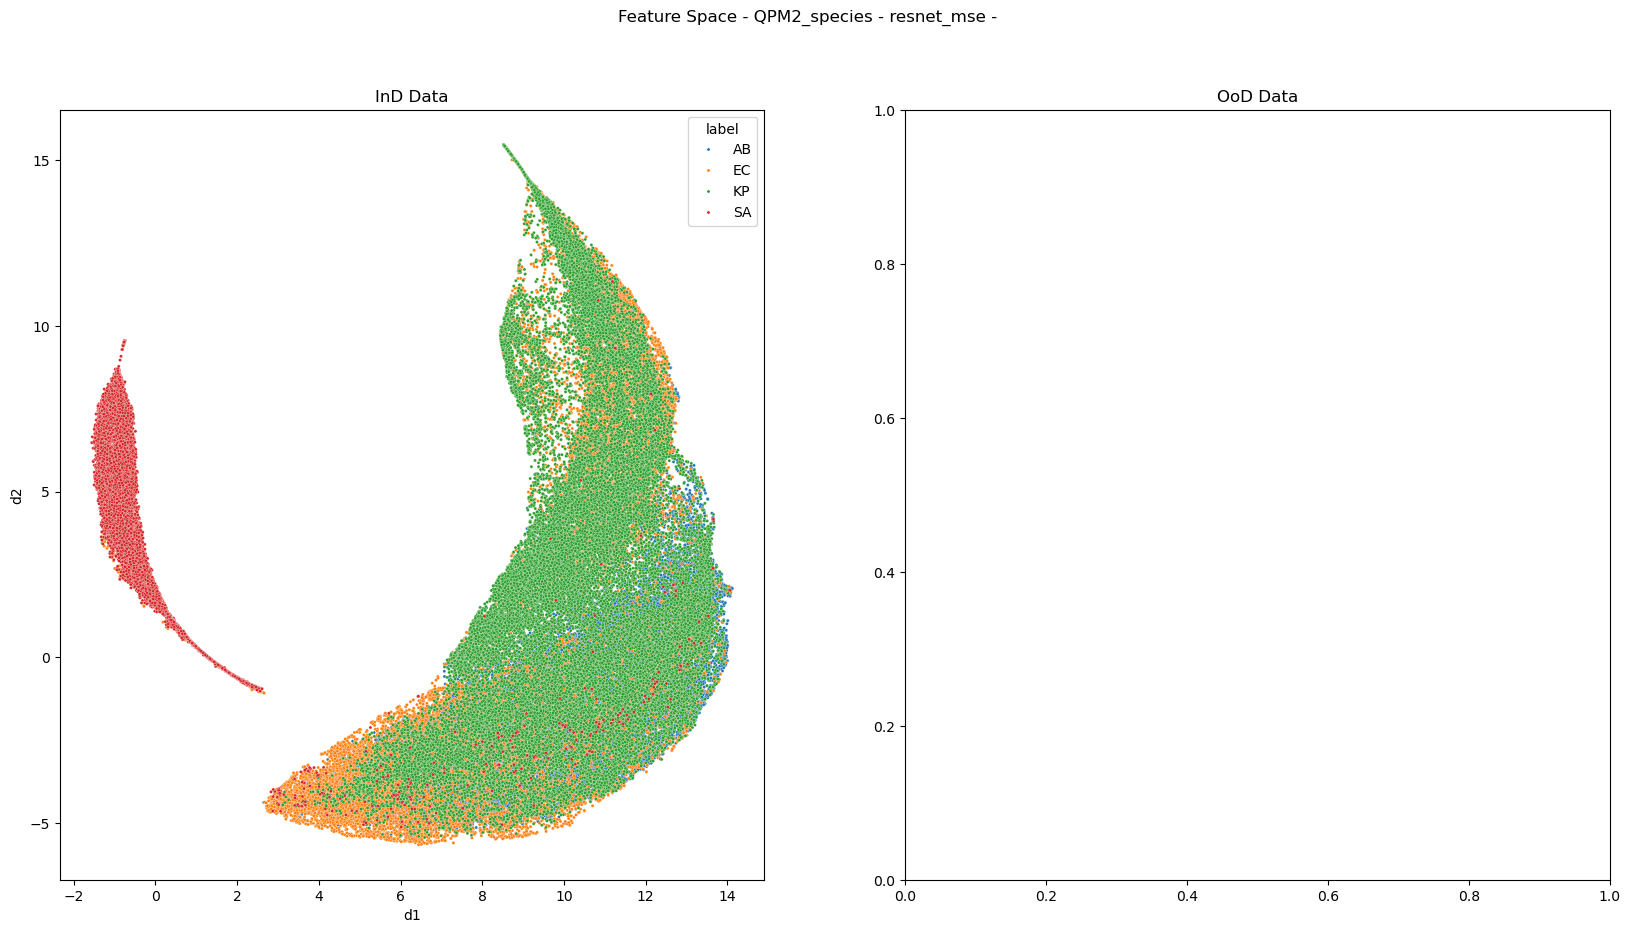

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

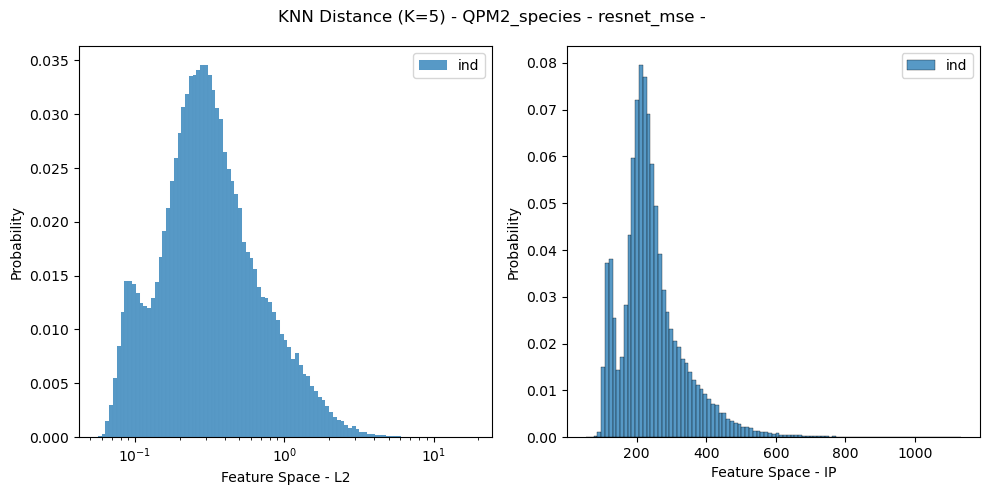

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
plt.tight_layout()
plt.show()

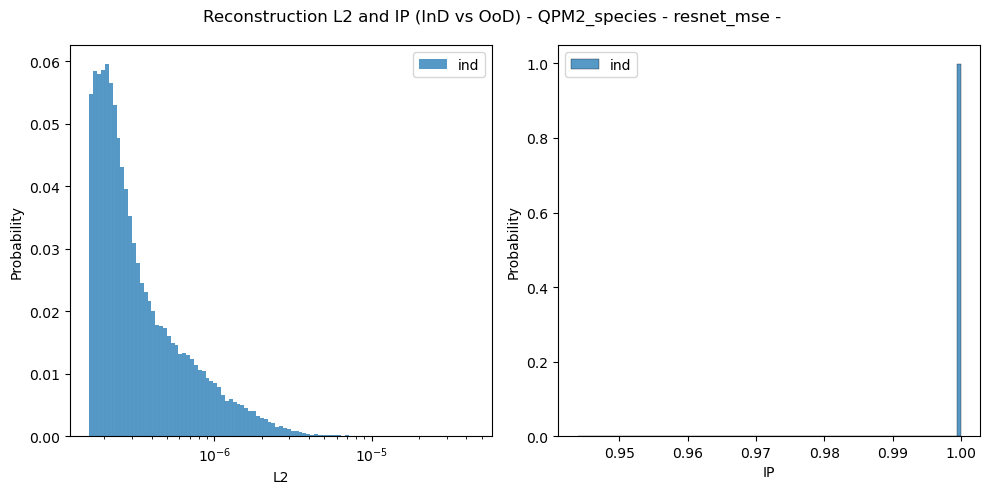

In [14]:
# plot reconstruction error of ind and ood data
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)